In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import time
from random import choice
from skimage.feature import hog
from skimage.measure import label, regionprops
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from vehicle_detection_utils import *
%matplotlib inline

# 1. Explore the Data

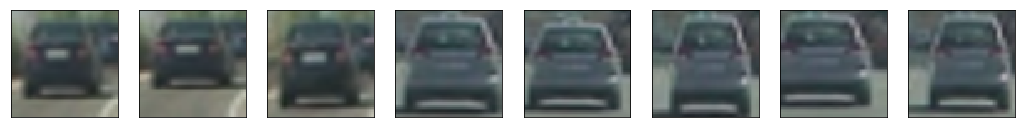

Total vehicle: 8792
Image size: (64, 64, 3)


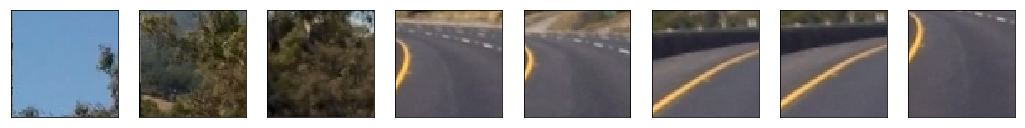

Total non-vehicle: 9666
Image size: (64, 64, 3)


In [2]:
# Grab all the training images
vehicles = glob.glob('training_data/vehicles/*/*.png')
non_vehicles = glob.glob('training_data/non-vehicles/*/*.png')

# Plot some sample vehicle images
img_cnt = 8
f, ax = plt.subplots(1, img_cnt, figsize = (18, 16))
for i in range(0, img_cnt):
    sample = mpimg.imread(vehicles[i])
    ax[i].imshow(sample)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()
print('Total vehicle: %d' %len(vehicles))
img_size = sample.shape
print('Image size: {}'.format(img_size))

# Plot some sample non-vehicle images
f, ax = plt.subplots(1, img_cnt, figsize = (18, 16))
for i in range(0, img_cnt):
    sample = mpimg.imread(non_vehicles[i])
    ax[i].imshow(sample)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()
print('Total non-vehicle: %d' %len(non_vehicles))
img_size = sample.shape
print('Image size: {}'.format(img_size))

In [3]:
# Get the X training tdata
X = np.zeros( (len(vehicles) + len(non_vehicles), *img_size), dtype=np.float32)
i = 0
for img in vehicles:
    X[i,:,:,:] = mpimg.imread(img)
    i += 1
for img in non_vehicles:    
    X[i,:,:,:] = mpimg.imread(img)
    i += 1
    
print(X.shape)

(18458, 64, 64, 3)


In [4]:
# Get the y training data
y = np.hstack((np.ones(len(vehicles)), np.zeros(len(non_vehicles)))).astype(np.float32)
print(y.shape)

(18458,)


### Save the raw data as a pickle

In [ ]:
raw_pickle = {}
raw_pickle['X'] = X
raw_pickle['y'] = y
with open('training_data/raw_pickle.p','wb') as output_file:
    pickle.dump(raw_pickle, output_file)

### Load the raw data pickle

In [ ]:
with open('training_data/raw_pickle.p', 'rb') as input_file:
    p = pickle.load(input_file)
X, y = p['X'], p['y']

# 2. Feature Selection

In [5]:
ORIENT = 9
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2

# Function to plot example images on HOG
def plot_hog_examples(img, orient = 9, pix_per_cell = 8, cell_per_block = 2):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    _, ax = plt.subplots(1, 6, figsize = (18, 6))
    ax[0].imshow(img)
    ax[0].set_title('original')
    
    _, gray_hog = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis = True)
    ax[1].imshow(gray_hog, cmap = 'gray')
    ax[1].set_title('gray hog')
    
    _, h_hog = get_hog_features(hls[:,:,0], orient, pix_per_cell, cell_per_block, vis = True)
    ax[2].imshow(h_hog, cmap = 'gray')
    ax[2].set_title('h hog')
    
    _, l_hog = get_hog_features(hls[:,:,1], orient, pix_per_cell, cell_per_block, vis = True)
    ax[3].imshow(l_hog, cmap = 'gray')
    ax[3].set_title('l hog')
    
    _, s_hog = get_hog_features(hls[:,:,2], orient, pix_per_cell, cell_per_block, vis = True)
    ax[4].imshow(s_hog, cmap = 'gray')
    ax[4].set_title('s hog')
    
    _, v_hog = get_hog_features(hsv[:,:,2], orient, pix_per_cell, cell_per_block, vis = True)
    ax[5].imshow(v_hog, cmap = 'gray')
    ax[5].set_title('v hog')
    
    plt.show()

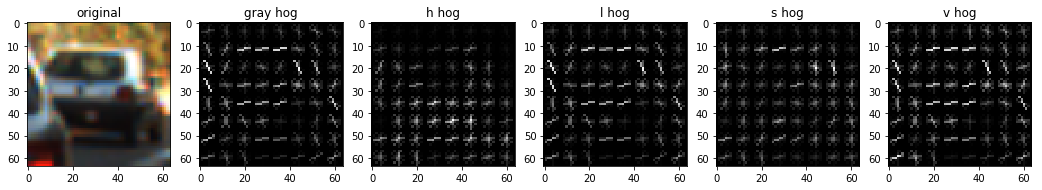

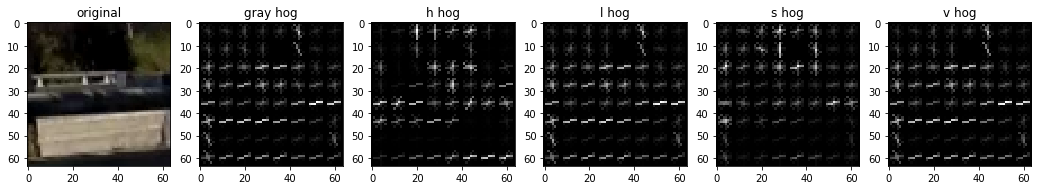

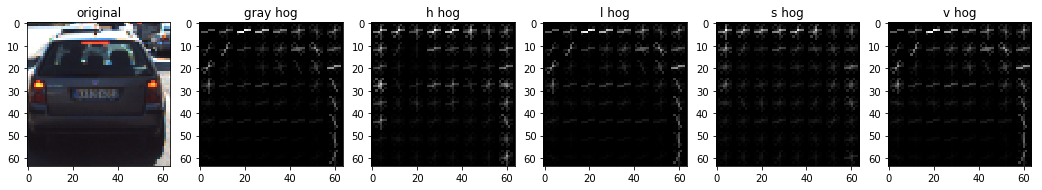

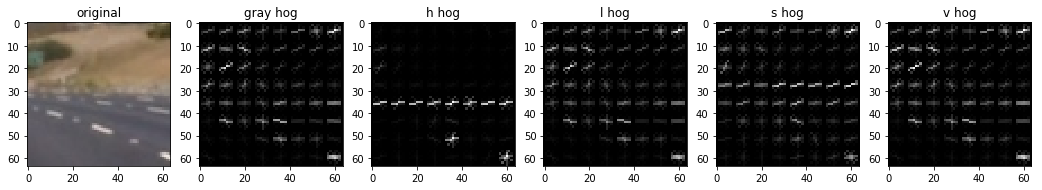

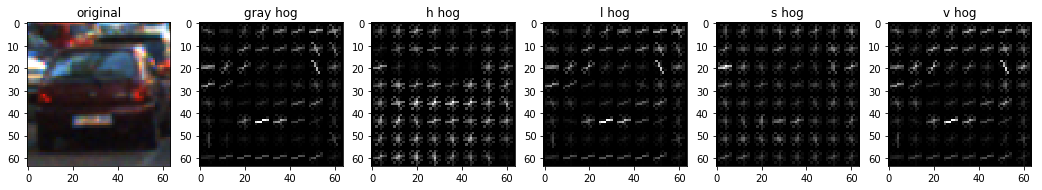

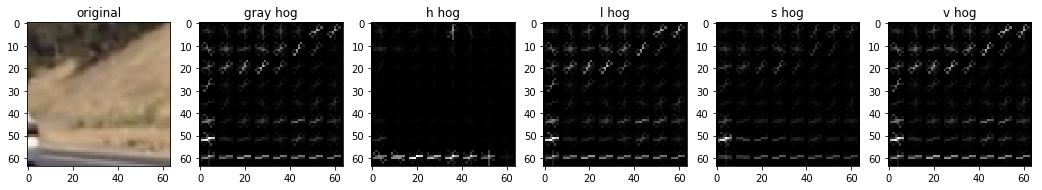

In [6]:
# Plot different HOGs from random images
for _ in range(0, 3):
    plot_hog_examples(mpimg.imread(choice(vehicles)), ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)
    plot_hog_examples(mpimg.imread(choice(non_vehicles)), ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)

In [7]:
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t1 = time.time()
features = extract_features(X, 
                            color_space = color_space, 
                            orient = ORIENT, 
                            pix_per_cell = PIX_PER_CELL, 
                            cell_per_block = CELL_PER_BLOCK, 
                            hog_channel = hog_channel,
                            spatial_feat = True,
                            hist_feat = True)
t2 = time.time()
print(round(t2 - t1, 2), 'Seconds to extract features...' )

93.29 Seconds to extract features...


In [8]:
X = np.array(features).astype(np.float32)
print('Before scaler, mean:{}, std:{}'.format(np.mean(X),np.std(X)) )
X_scaler = StandardScaler().fit(features)
scaled_X = X_scaler.transform(features)
print('After scaler, mean:{}, std:{}'.format(np.mean(scaled_X),np.std(scaled_X)) )
print(scaled_X.shape, y.shape)

Before scaler, mean:19.970869064331055, std:63.105220794677734
After scaler, mean:6.665678516877713e-17, std:1.000000000000002
(18458, 8460) (18458,)


# 3. Train Classifier

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=12345)
print('Training data size: {}'.format(X_train.shape[0]))
print('Test data size: {}'.format(X_test.shape[0]))
svc = LinearSVC()
clf = CalibratedClassifierCV(svc)
t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t1, 2), 'Seconds to train SVC...' )
print('Train Accuracy of SVC = ', round(clf.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Training data size: 14766
Test data size: 3692
29.64 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9943


# 4. Sliding Window

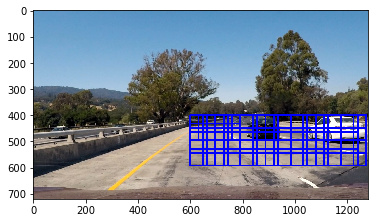

In [39]:
y_start_stops = [[400, 500],
                 [400, 600],
                 [400, 600]]
x_start_stops = [[600, 800],
                 [600, 1280],
                 [600, 1280]]
xy_windows = [(64, 64),
              (96, 96),
              (128, 128)]
test_img = mpimg.imread('test_images/test1.jpg')
windows = []
for i in range(len(xy_windows)):
    windows  += slide_window(test_img.shape, x_start_stop=x_start_stops[i], y_start_stop=y_start_stops[i], 
                           xy_window=xy_windows[i],xy_overlap=(0.5, 0.5))
window_img = draw_boxes(test_img, windows, color=(0,0,255), thick = 6)
plt.figure()
plt.imshow(window_img);

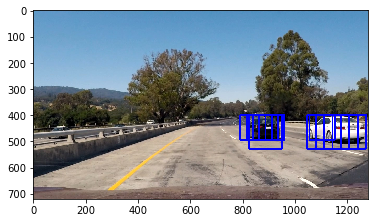

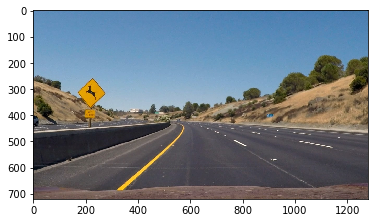

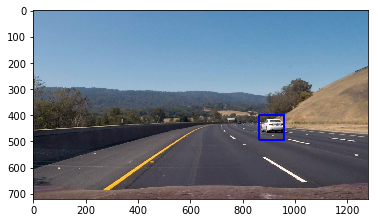

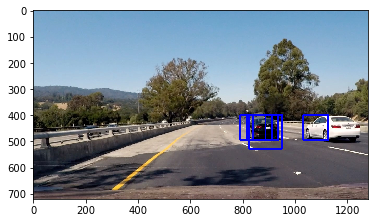

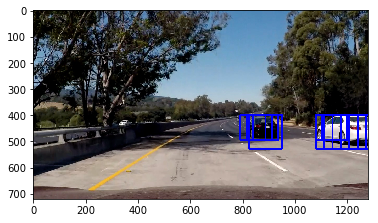

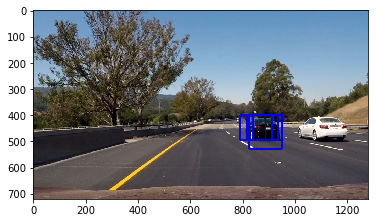

In [29]:
test_imgs = glob.glob('test_images/*.jpg')
for img in test_imgs:
    img = mpimg.imread(img)
    proc_img = img.astype(np.float32)/255.0   
    windows = []
    for i in range(len(xy_windows)):
        windows  += slide_window(img.shape, x_start_stop=x_start_stops[i], y_start_stop=y_start_stops[i], 
                               xy_window=xy_windows[i],xy_overlap=(0.75, 0.5))
    on_windows = search_windows(proc_img, windows, clf, X_scaler, 'HLS', ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, 'ALL')
    window_img = draw_boxes(img, on_windows, color=(0,0,255), thick = 6)
    plt.figure()
    plt.imshow(window_img)
    plt.show()

# 5. Heat Map

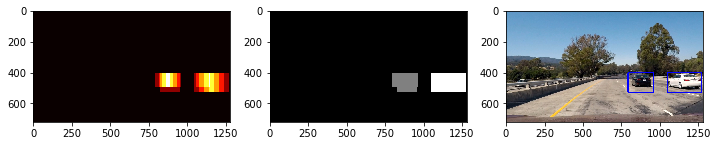

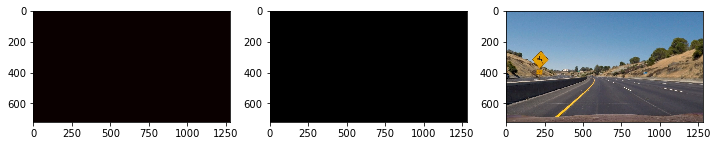

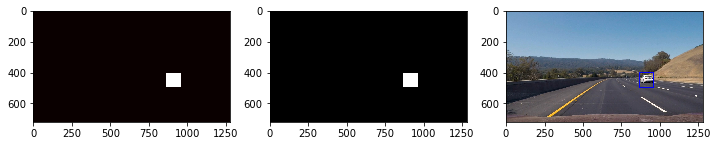

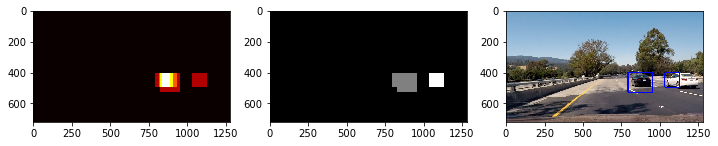

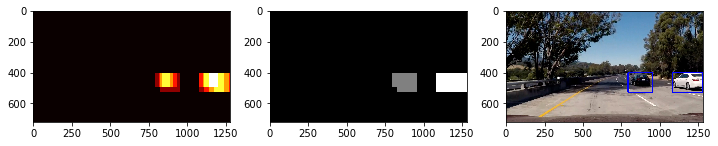

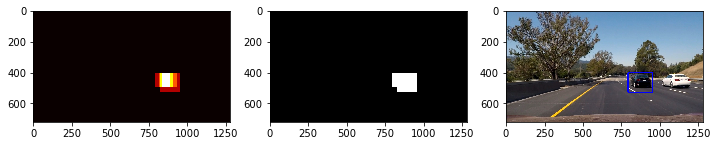

In [30]:
test_imgs = glob.glob('test_images/*.jpg')
for img in test_imgs:
    img = mpimg.imread(img)
    proc_img = img.astype(np.float32)/255.0
    windows = []
    for i in range(len(xy_windows)):
        windows  += slide_window(img.shape, x_start_stop=x_start_stops[i], y_start_stop=y_start_stops[i], 
                               xy_window=xy_windows[i],xy_overlap=(0.75, 0.5))
    on_windows = search_windows(proc_img, windows, clf, X_scaler, 'HLS', ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, 'ALL')
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, on_windows)
    heatmap =apply_threshold(heatmap, 0)
    labels = label(heatmap)
    bbox_list = bbox_from_labels(labels)
    window_img = draw_boxes(img, bbox_list, color=(0,0,255), thick = 6)
    _, ax = plt.subplots(1, 3, figsize = (12, 8))
    ax[0].imshow(heatmap, cmap = 'hot')
    ax[1].imshow(labels[0], cmap = 'gray')
    ax[2].imshow(window_img)
    plt.show()

# 6. Video

In [42]:
class vehicle_detector():
    def __init__(self):
        self.x_shape = 1280
        self.y_shape = 720
        self.windows = self.get_windows(self.x_shape, self.y_shape)
        self.last_on_windows = []
    def get_windows(self, x_shape, y_shape):
        windows = []
        for i in range(len(xy_windows)):
            windows  += slide_window([y_shape, x_shape], 
                                     x_start_stop=x_start_stops[i], 
                                     y_start_stop=y_start_stops[i], 
                                     xy_window=xy_windows[i],
                                     xy_overlap=(0.75, 0.5))
        return windows
    
    def pipeline(self,img):
        proc_img = img.astype(np.float32)/255.0
        on_windows = []
        for window in self.windows:
            window_img = proc_img[window[0][1]:window[1][1], window[0][0]:window[1][0], :]
            test_img = cv2.resize(window_img, (64, 64))
            features = single_img_features(test_img, color_space=color_space, 
                                            orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                                            cell_per_block=CELL_PER_BLOCK, 
                                            hog_channel=hog_channel,
                                            spatial_feat=True,
                                            hist_feat=True,
                                            hog_feat=True
                                            )
            test_features = X_scaler.transform(np.array(features).reshape(1, -1))
            prediction = clf.predict_proba(test_features)[0][1]
            if prediction > 0.75:
                on_windows.append(window)
        if len(on_windows) > 0:
            heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
            heatmap = add_heat(heatmap, on_windows)
            for i in range(len(self.last_on_windows)):
                heatmap = add_heat(heatmap, self.last_on_windows[i])
            self.last_on_windows.append(on_windows)
            if(len(self.last_on_windows) > 5):
                self.last_on_windows.pop(0)
            heatmap =apply_threshold(heatmap, 2)
            labels = label(heatmap)
            bbox_list = bbox_from_labels(labels)
            window_img = draw_boxes(img, bbox_list, color=(0,0,255), thick = 6)
            return window_img
        else:
            return img

In [43]:
VehicleDetector = vehicle_detector()
clip = VideoFileClip('project_video.mp4')
project_clip = clip.fl_image(VehicleDetector.pipeline)

%time project_clip.write_videofile('output_images/proc_project_video.mp4', audio = False)

[MoviePy] >>>> Building video output_images/proc_project_video.mp4
[MoviePy] Writing video output_images/proc_project_video.mp4



100%|█████████▉| 1260/1261 [22:10<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/proc_project_video.mp4 

CPU times: user 20min 19s, sys: 28.2 s, total: 20min 47s
Wall time: 22min 12s
